# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Spectral Baseline (SpectraNet) Implementation**

This notebook contains the full implementation of **SpectraNet** on the Breast Ultrasound Images (BUSI) dataset. We use the **SpectraNet-2** variant here, for comparisons with **S³F-Net** and the Baseline Spatial CNN. The full architecture is customizable, feel free to do so. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR BUSI)
# ==============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_PATH = "/content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT"
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "SpectraNet_2_BUSI.keras")

In [ ]:
# ==============================================================================
# BLOCK 2: DATA LOADING AND PREPROCESSING FOR BUSI
# ==============================================================================
def load_busi_dataset(dataset_path):
    """Loads images and labels from the BUSI dataset structure."""
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    if not images: raise ValueError("No images loaded.")
    return np.array(images), np.array(labels), categories

try:
    images, labels, CLASS_NAMES = load_busi_dataset(DATASET_PATH)
    print(f"Dataset loaded successfully: {len(images)} images.")
    indices = np.arange(len(images))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
    X_train, X_test = images[train_indices], images[test_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"\nClass names: {CLASS_NAMES}")
    print(f"Data split: {len(X_train)} training, {len(X_test)} testing samples.")
    X_val, y_val = X_test, y_test

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading BUSI dataset from: /content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT
Dataset loaded successfully: 780 images.

Class names: ['benign', 'malignant', 'normal']
Data split: 624 training, 156 testing samples.


## **SpectraNet-2 Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SpectraNet with 2 SpectralFilter Layers)
# ==============================================================================
# This block defines the SpectraNet-2 Architecture

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = SpectralFilterLayer(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- SpectraNet Model Builder ---
def build_spectral_only_classifier(input_shape, num_classes):
    """Builds the SpectraNet-2 model for classification."""
    inputs = layers.Input(input_shape)

    # 1. Building the spectral summary branch
    spectral_vector = build_spectral_summary_branch(inputs)

    # 2. Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(spectral_vector)

    model = models.Model(inputs, outputs, name="SpectraNet_2_Classifier")

    # Compiling with the same optimizer and CE loss as S³F-Net
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("SpectraNet model architecture is ready for BUSI.")

Spectral-Only model architecture definition is ready for BUSI.


## **Model Training**

In [ ]:
# ==============================================================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ==============================================================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        weighted_f1 = f1_score(y_val, y_pred, average='weighted')
        logs['val_f1_weighted'] = weighted_f1

        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")

        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "SpectraNet_2_BUSI.keras")

# --- Building the Model ---
print("\n--- Building SpectraNet ---")
classifier_model = build_spectral_only_classifier(X_train.shape[1:], num_classes=len(CLASS_NAMES))

# --- Compiling the model with standard cross-entropy ---
classifier_model.compile(optimizer=optimizers.Adam(0.0003),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
classifier_model.summary()

# --- Defining Callbacks ---
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test),
                              filepath=CLASSIFIER_MODEL_PATH,
                              patience=60)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=40,
                                        min_lr=1e-6,
                                        verbose=1)

# --- Training the Model ---
print("\n--- Training (Monitoring Weighted F1-Score) ---")
history = classifier_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback, reduce_lr]
)

print("\n--- Training Finished ---")


--- Building Spectral-Net ---


Model: "Spectral_Only_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_conv_layer             │ (None, 256, 256, 32)   │     2,113,568 │
│ (SpectralConvLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_conv_layer_1           │ (None, 256, 256, 64)   │   135,266,368 │
│ (SpectralConvLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 256, 256, 64)   │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 128)  │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │             

 Total params: 137,392,083 (524.11 MB)

 Trainable params: 137,391,467 (524.11 MB)

 Non-trainable params: 616 (2.41 KB)


--- Training (Monitoring Weighted F1-Score) ---
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2981 - loss: 1.3035 - val_f1_weighted: 0.0511 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/SpectraNet_2_BUSI.keras)
39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 801ms/step - accuracy: 0.2990 - loss: 1.3041 - val_accuracy: 0.1731 - val_loss: 1.1132 - val_f1_weighted: 0.0511 - learning_rate: 3.0000e-04
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3786 - loss: 1.0765 - val_f1_weighted: 0.0511
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.3796 - loss: 1.0764 - val_accuracy: 0.1731 - val_loss: 1.1163 - val_f1_weighted: 0.0511 - learning_rate: 3.0000e-04
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4449 - loss: 1.0150 - val_f1_weighted: 0.0511
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.4450 - loss: 1.0154 - val_accuracy: 0.1731 - val_loss: 1.1000 - val_f1_weighted: 0.0511 - learning_rate: 3.0000e-04
Epoch

## **Evaluation**



--- Final Evaluation on Unseen Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/SpectraNet_2_BUSI.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.4861
Test Accuracy:  0.8205
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.7996
Weighted F1 Score:0.8175
Cohen's Kappa:    0.6874
MCC:              0.6905
AUC-ROC (Macro):  0.9337
AUC-ROC (Weighted):  0.9294

--- Classification Report ---
              precision    recall  f1-score   support

      benign     0.8298    0.8966    0.8619        87
   malignant     0.8235    0.6667    0.7368        42
      normal     0.7857    0.8148    0.8000        27

    accuracy                         0.8205       156
   macro avg     0.8130    0.7927    0.7996       156
weighted avg     0.8205    0.8205    0.8175       156



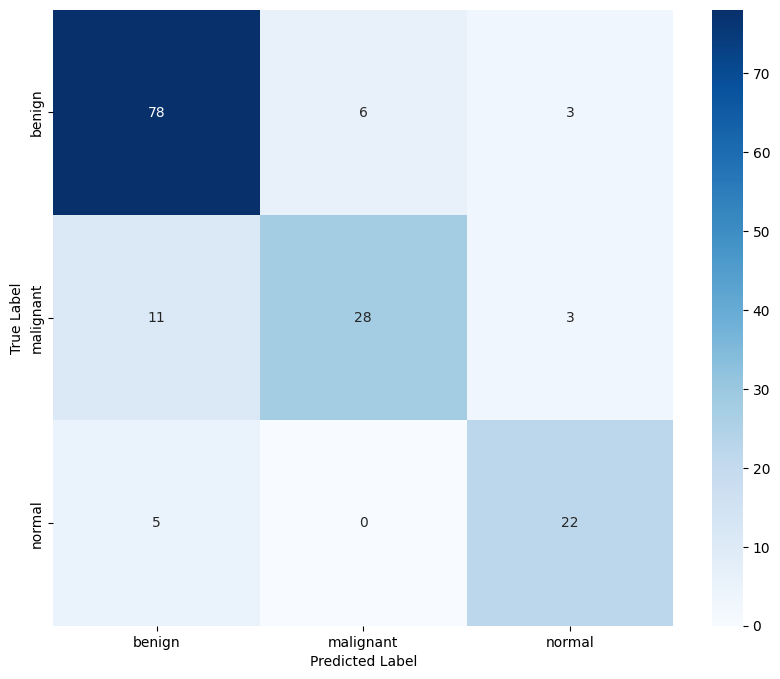


--- Training History Plots ---


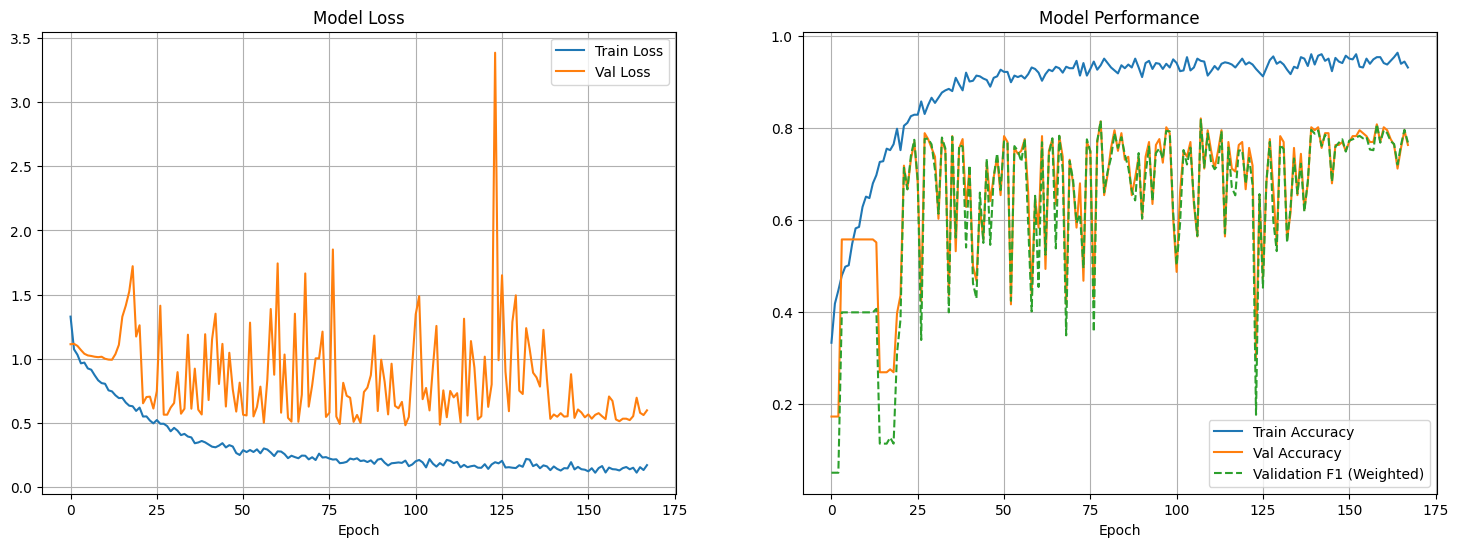


--- ROC Curve Analysis ---


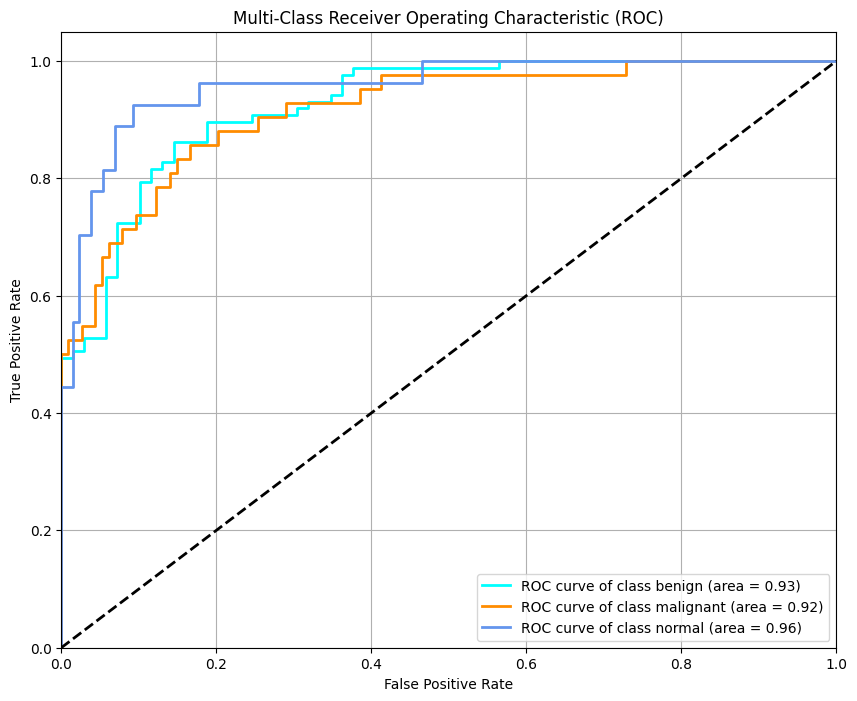


--- Script Finished ---


In [ ]:
# ==============================================================================
# BLOCK 5: EVALUATION
# ==============================================================================

print("\n\n--- Final Evaluation on Test Set ---")
try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(
        CLASSIFIER_MODEL_PATH,
        custom_objects={'SpectralFilterLayer': SpectralFilterLayer}
    )

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Weighted):  {weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('SpectraNet-2 on BUSI')
    plt.show()

    # --- 6. Plotting Training History ---
    print("\n--- Training History Plots ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    if 'val_f1_weighted' in history.history:
        ax2.plot(history.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
    ax2.set_title('Model Performance')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")